<a href="https://colab.research.google.com/github/kskaran94/Extreme-rare-Classification/blob/master/Extreme_Rare_Classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Libraries used**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Input, regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, precision_recall_curve
import seaborn as sns
import numpy as np
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
SEED = 123


Using TensorFlow backend.


In [2]:
uploaded = files.upload()

Saving processminer-rare-event-mts - data.csv to processminer-rare-event-mts - data.csv


## **Reading Data**

This is a binary labeled data from a pulp-and-paper mill for sheet breaks. A single sheet break can cause a loss of thousands of dollars to the mill. Even a 5% improvement is useful for the mill.



The data can be downloaded from [here](https://docs.google.com/forms/d/e/1FAIpQLSdyUk3lfDl7I5KYK_pw285LCApc-_RcoC0Tf9cnDnZ_TWzPAw/viewform)

In [0]:
data = pd.read_csv('/content/processminer-rare-event-mts - data.csv')

In [4]:
data.columns

Index(['time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60', 'x61'],
      dtype='object')

Text(0, 0.5, 'Frequency')

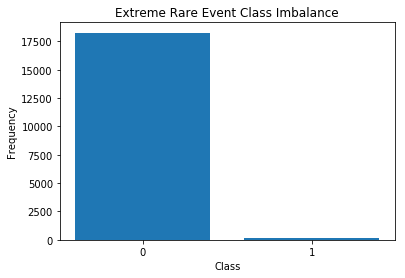

In [5]:
plt.bar(data['y'].value_counts().index,data['y'].value_counts())
plt.xticks([0,1])
plt.xlabel('Class')
plt.title('Extreme Rare Event Class Imbalance')
plt.ylabel('Frequency')

## **Data Preprocessing**

Objective : To predict a sheet-break before it occurs.  Predict the break 4 minutes in advance.

In [6]:
data.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451973,-0.105282,96,-134.27786,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.63286,-0.657095,-0.434947,-108.77597,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450451,-0.092430,96,-134.48019,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.37895,-0.875629,-1.125819,-108.84897,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.94659,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.12309,-0.037775,-0.519541,-109.08658,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.00259,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.69145,-0.987410,0.674524,-109.56277,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445879,-0.131630,96,-133.14571,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.25786,-0.238445,-0.063044,-110.03891,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


To predict 4 minutes in advance , we need to shift the labels 2 rows up when a positively labeled data is encountered.  

This function will shift the binary labels in a dataframe.
The curve shift will be with respect to the 1s. 
For example, if shift is -2, the following process
will happen: if row n is labeled as 1, then
- Make row (n+shift_by):(n+shift_by-1) = 1.
- Remove row n.
i.e. the labels will be shifted up to 2 rows up.

Inputs:
df       A pandas dataframe with a binary labeled column. 
         This labeled column should be named as 'y'.
shift_by An integer denoting the number of rows to shift.

Output
df       A dataframe with the binary labels shifted by shift.



In [0]:
## To build this model, we will shift the labels 2 rows up (which corresponds to 4 minutes). 

sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df
      
    
new_data = curve_shift(data,-2)

### **Train_test_split**

In [0]:
# Remove time column, and the categorical columns

new_data = new_data.drop(['time', 'x28', 'x61'], axis=1)

train, test = train_test_split(new_data, test_size=0.2, random_state=SEED)

train, val = train_test_split(train, test_size=0.2, random_state=SEED)

X_train_0 = train[train['y']==0].drop(['y'], axis = 1)
X_train = train.drop(['y'], axis = 1)

X_test_0 = test[test['y']==0].drop(['y'], axis =1)
X_test = test.drop(['y'], axis = 1)


X_val_0 = val[val['y']==0].drop(['y'], axis =1)
X_val = val.drop(['y'], axis = 1)


y_train_0 = train[train['y']==0]['y']

y_test_0 = test[test['y']==0]['y']

y_val_0 = val[val['y']==0]['y']



### **Standardization**

Standardize all the continous variables . The  Standardization is fitted on Train and transformed on Train, Validation and Test

In [0]:
scaler = StandardScaler().fit(X_train_0)

X_train_0_rescaled = scaler.transform(X_train_0)
X_test_0_rescaled = scaler.transform(X_test_0)
X_val_0_rescaled = scaler.transform(X_val_0)

X_val_rescaled = scaler.transform(X_val)

X_test_rescaled = scaler.transform(X_test)


## **AutoEncoder Classifier**

Train an autoencoder with 5 Dense layers and one input layer

In [10]:
nb_epoch = 200
batch_size = 128
input_dim = X_train_0.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

W0617 14:33:56.169156 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 14:33:56.171145 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 14:33:56.186853 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 59)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1920      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
_________________________________________________________________


## **Fit The AutoEncoder**

Compile the autoencoder with loss = 'mean_squared_error' and optimizer ='adam ' (These can be tweaked)
And fit the autoencoder on train with validation on Validation data

In [11]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(X_train_0_rescaled, X_train_0_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val_0_rescaled, X_val_0_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history




W0617 14:33:56.295239 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0617 14:33:58.112580 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0617 14:33:58.392510 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 11541 samples, validate on 2883 samples


W0617 14:33:58.872139 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0617 14:33:58.873423 140084437407616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/200
11541/11541 [==============================] - 1s 50us/step - loss: 2.1000 - acc: 0.0428 - val_loss: 1.5192 - val_acc: 0.0451
Epoch 2/200
11541/11541 [==============================] - 0s 16us/step - loss: 1.1812 - acc: 0.0457 - val_loss: 0.9218 - val_acc: 0.0624
Epoch 3/200
11541/11541 [==============================] - 0s 17us/step - loss: 0.7968 - acc: 0.0705 - val_loss: 0.7156 - val_acc: 0.1145
Epoch 4/200
11541/11541 [==============================] - 0s 16us/step - loss: 0.6638 - acc: 0.1236 - val_loss: 0.6318 - val_acc: 0.1259
Epoch 5/200
11541/11541 [==============================] - 0s 16us/step - loss: 0.5940 - acc: 0.1397 - val_loss: 0.5733 - val_acc: 0.1283
Epoch 6/200
11541/11541 [==============================] - 0s 16us/step - loss: 0.5425 - acc: 0.1470 - val_loss: 0.5279 - val_acc: 0.1530
Epoch 7/200
11541/11541 [==============================] - 0s 16us/step - loss: 0.5038 - acc: 0.1528 - val_loss: 0.4959 - val_acc: 0.1592
Epoch 8/200
11541/11541 [=========

Train and Valid Loss over the epochs

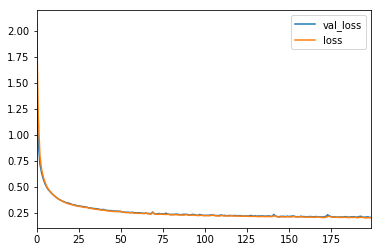

In [12]:
pd.DataFrame(history).drop(['acc','val_acc'], axis=1).plot()

Use the validation set to identify a threshold for classifying the class. 

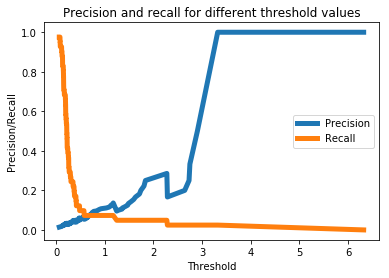

In [13]:
valid_x_predictions = autoencoder.predict(X_val_rescaled)
mse = np.mean(np.power(X_val_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': val['y']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

The Threshold is identified as 0.4 . As it provides a reasonable trade-off between precision and recall.

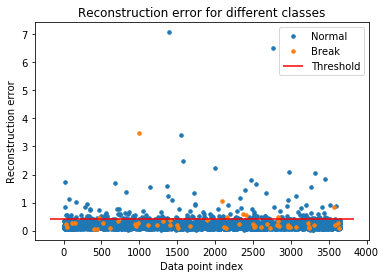

In [14]:
test_x_predictions = autoencoder.predict(X_test_rescaled)
mse = np.mean(np.power(X_test_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test['y']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

The orange and blue dots above the threshold line represents the True Positive and False Positive, respectively.

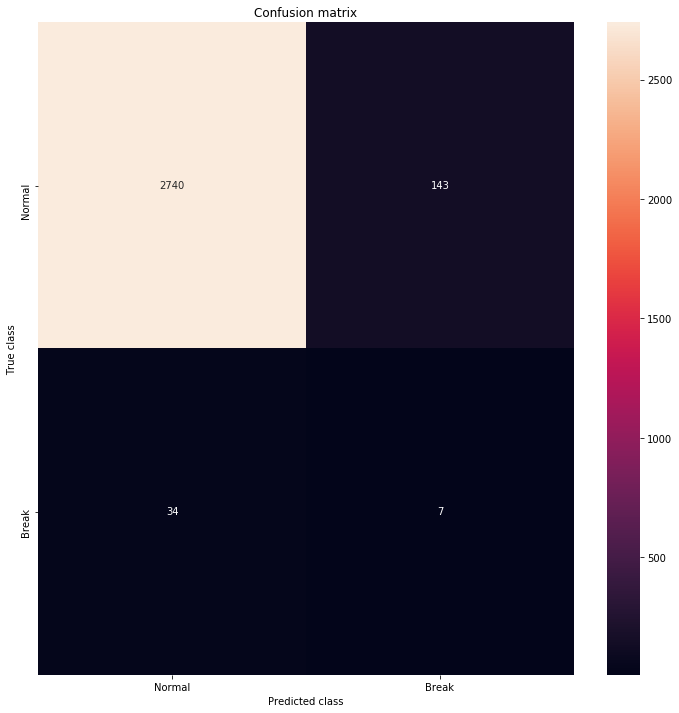

In [15]:
LABELS = ["Normal","Break"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We could predict 9 out of 41 breaks instances. Note that these instances include 2 or 4 minute ahead predictions. This is around 20%, which is a good recall rate for the paper industry.

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
def make_model(optimizer="adam",   encoding_dim = 32, learning_rate = 1e-3):
  input_dim = X_train_0.shape[1] #num of predictor variables, 
  hidden_dim = int(encoding_dim / 2)
  

  input_layer = Input(shape=(input_dim, ))
  encoder = Dense(encoding_dim, activation="relu", 
                  activity_regularizer=regularizers.l1(learning_rate))(input_layer)
  encoder = Dense(hidden_dim, activation="relu")(encoder)
  decoder = Dense(hidden_dim, activation="relu")(encoder)
  decoder = Dense(encoding_dim, activation="relu")(decoder)
  decoder = Dense(input_dim, activation="linear")(decoder)
  autoencoder = Model(inputs=input_layer, outputs=decoder)


  autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
    
  return autoencoder
clf = KerasClassifier(make_model)
param_grid = {'learning_rate': [1e-3,1e-2, 1e-4],  
              'encoding_dim': [32, 16,8]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)
grid.fit(X_train_0_rescaled, X_train_0_rescaled, epochs=100, verbose =0)

3847/3847 [==============================] - 1s 296us/step


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f67aa89a588>,
             iid='warn', n_jobs=None,
             param_grid={'encoding_dim': [32, 16, 8],
                         'learning_rate': [0.001, 0.01, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
grid.best_params_

{'encoding_dim': 32, 'learning_rate': 0.0001}